## Hodge-compositional Edge Gaussian Process

In [66]:
import os

# set the current working directory
curr_path = os.getcwd().split("/")[:-2]
curr_path = "/".join(curr_path)
os.chdir(curr_path)

In [67]:
import numpy as np
# read dataset
from pytspl import load_dataset

sc, coordinates, flow = load_dataset("forex")

# get the y from flow dict
y = np.fromiter(flow.values(), dtype=float)

Generating coordinates using spring layout.
Num. of nodes: 25
Num. of edges: 210
Num. of triangles: 770
Shape: (25, 210, 770)
Max Dimension: 2
Coordinates: 25
Flow: 210


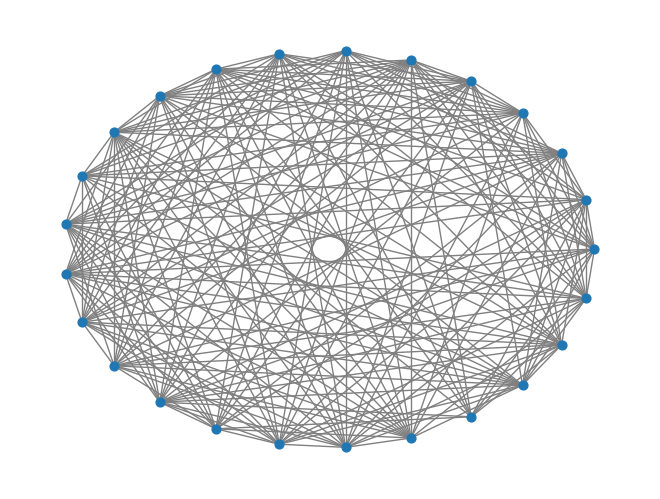

In [68]:
import networkx as nx

nodes = sc.nodes
edges = sc.edges
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

params = {
    "edge_color": "gray",
    "node_size": 40,
    "arrowsize": 20,
}

nx.draw_circular(G, with_labels=False, **params)

In [69]:
from pytspl.hogde_gp import HodgeGPTrainer

# create the trainer object
hogde_gp = HodgeGPTrainer(sc=sc, y=y)

In [75]:
# set the training ratio
train_ratio = 0.2
# set the data normalization
data_normalization = False

# split the data into training and testing sets
x_train, y_train, x_test, y_test, x, y  = hogde_gp.train_test_split(
    train_ratio=train_ratio, 
    data_normalization=data_normalization,
    seed=4
)

x_train: (42,)
x_test: (168,)
y_train: (42,)
y_test: (168,)


In [76]:
from pytspl.hogde_gp.kernel_serializer import KernelSerializer

# set the kernel parameters

kernel_type = "matern" # kernel type
data_name = "forex" # data set name

# get the eigenpairs
eigenpairs = hogde_gp.get_eigenpairs()

# serialize the kernel
kernel = KernelSerializer().serialize(eigenpairs=eigenpairs, kernel_type=kernel_type, data_name=data_name)

In [77]:
import gpytorch
from pytspl.hogde_gp import ExactGPModel

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood, kernel, mean_function=None)

In [78]:
model

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernelForex(
      (raw_kappa_down_constraint): Positive()
      (raw_kappa_up_constraint): Positive()
      (raw_kappa_constraint): Positive()
      (raw_mu_constraint): Positive()
      (raw_mu_down_constraint): Positive()
      (raw_mu_up_constraint): Positive()
      (raw_h_constraint): Positive()
      (raw_h_down_constraint): Positive()
      (raw_h_up_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [79]:
import torch
output_device = "cpu"

if torch.cuda.is_available():
   model = model.to(output_device)
   likelihood = likelihood.to(output_device)

In [81]:
# train the model
model.train()
likelihood.train()
hogde_gp.train(model, likelihood, x_train, y_train, learning_rate=0.1)

Iteration 1/1000 - Loss: -0.170 
Iteration 2/1000 - Loss: 7.126 
Iteration 3/1000 - Loss: 0.308 
Iteration 4/1000 - Loss: 1.376 
Iteration 5/1000 - Loss: 4.044 
Iteration 6/1000 - Loss: 3.030 
Iteration 7/1000 - Loss: 0.773 
Iteration 8/1000 - Loss: -0.168 
Iteration 9/1000 - Loss: 0.663 
Iteration 10/1000 - Loss: 1.768 
Iteration 11/1000 - Loss: 1.784 
Iteration 12/1000 - Loss: 0.878 
Iteration 13/1000 - Loss: 0.013 
Iteration 14/1000 - Loss: -0.108 
Iteration 15/1000 - Loss: 0.380 
Iteration 16/1000 - Loss: 0.827 
Iteration 17/1000 - Loss: 0.786 
Iteration 18/1000 - Loss: 0.396 
Iteration 19/1000 - Loss: 0.099 
Iteration 20/1000 - Loss: 0.046 
Iteration 21/1000 - Loss: 0.082 
Iteration 22/1000 - Loss: 0.158 
Iteration 23/1000 - Loss: 0.267 
Iteration 24/1000 - Loss: 0.353 
Iteration 25/1000 - Loss: 0.347 
Iteration 26/1000 - Loss: 0.260 
Iteration 27/1000 - Loss: 0.158 
Iteration 28/1000 - Loss: 0.080 
Iteration 29/1000 - Loss: 0.024 
Iteration 30/1000 - Loss: 0.000 
Iteration 31/100

In [82]:
# evaluate the model
predictions = hogde_gp.predict(model, likelihood, x_test, y_test)
prediction_mean, prediction_variance = predictions.mean, predictions.variance
prediction_mean, prediction_variance = np.asarray(prediction_mean.cpu().detach()), np.asarray(prediction_variance.cpu().detach())

Test MAE: 5.540694110095501e-05
Test MSE: 4.7717927387225245e-09
Test R2: 1.0
Test MLSS: -3.294430732727051
Test NLPD: -3.5507471561431885


In [83]:
# get the trained model parameters
hogde_gp.get_model_parameters()

{'raw_noise': 0.00010002510680351406,
 'raw_mu': 0.6931471824645996,
 'raw_mu_down': 0.6705738306045532,
 'raw_mu_up': 2.148306369781494,
 'raw_kappa': 0.6931471824645996,
 'raw_kappa_down': 39.97739791870117,
 'raw_kappa_up': 0.02517639473080635,
 'raw_h': 0.6931471824645996,
 'raw_h_down': 31.798500061035156,
 'raw_h_up': 0.053553808480501175,
 'raw_outputscale': 11.325119972229004}

In [84]:
K, variance = hogde_gp.build_matern_kernel()

{'raw_noise': 0.00010002510680351406, 'raw_mu': 0.6931471824645996, 'raw_mu_down': 0.6705738306045532, 'raw_mu_up': 2.148306369781494, 'raw_kappa': 0.6931471824645996, 'raw_kappa_down': 39.97739791870117, 'raw_kappa_up': 0.02517639473080635, 'raw_h': 0.6931471824645996, 'raw_h_down': 31.798500061035156, 'raw_h_up': 0.053553808480501175, 'raw_outputscale': 11.325119972229004}


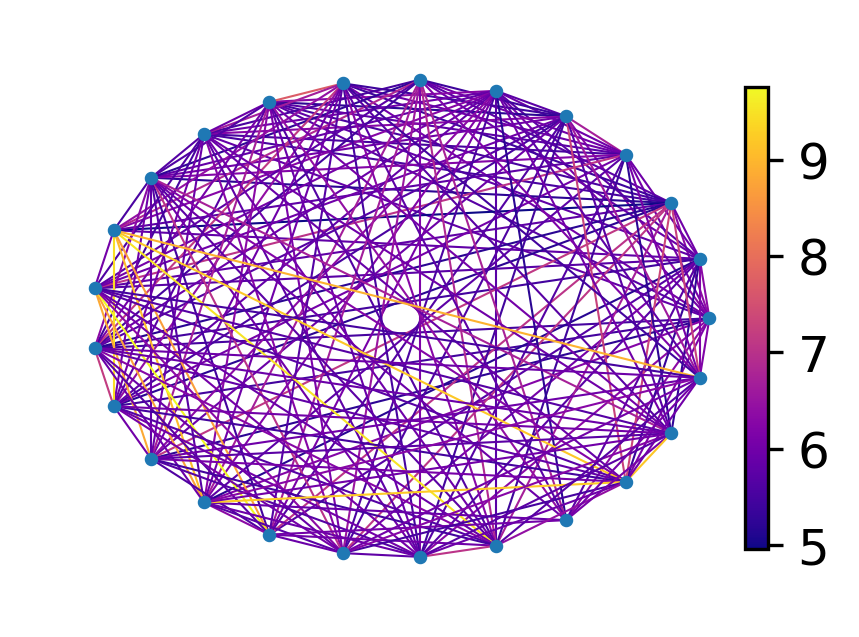

In [85]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(dpi=300, figsize=(4,2.5))

cmap=cmap=plt.cm.plasma
vmin = variance.min()
vmax = variance.max()


nx.draw_circular(G, edge_color=variance, edge_cmap=cmap, edge_vmin=vmin, edge_vmax=vmax, with_labels=False, node_size=5, width=0.5)

# plot the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cax = cbar.ax 
pos = cax.get_position() 
cax.set_position([pos.x0*0.92, pos.y0, pos.width * 0.8, pos.height]) 
cax.set_frame_on(True)
cbar.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
plt.show()

In [111]:
edges = [edge for edge in edges if edge in sc.edges]

train_ids = np.array(x_train.cpu().detach(), dtype=int)
test_ids = np.array(x_test.cpu().detach(), dtype=int)

train_edges = [edges[i] for i in train_ids]
test_edges = [edges[i] for i in test_ids]

y_train_vals = y_train.cpu().detach().numpy()
y_test_vals = y_test.cpu().detach().numpy()

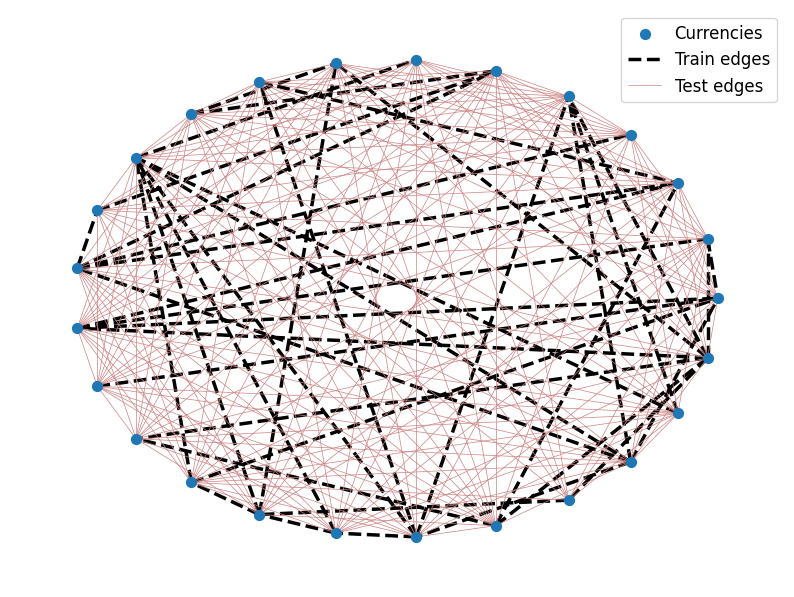

In [112]:
fig, ax = plt.subplots(figsize=(10,7.5))

nx.draw_circular(G, with_labels=False, edge_color='grey', edgelist=[], node_size=50, width=1)

# train edges
nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edgelist=train_edges, width=2.5, style='dashed')

# test edges
nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edgelist=test_edges, edge_color="#cd8282", width=0.5)

plt.legend(["Currencies", "Train edges", "Test edges"], fontsize=12)

/var/folders/py/wfd5gjj55nx4cqtdvltb22mw0000gp/T/ipykernel_12908/1989756009.py:6: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edge_cmap=cmap, edge_color=y_train_vals, edgelist=train_edges, width=1.5, style='dashed')
/var/folders/py/wfd5gjj55nx4cqtdvltb22mw0000gp/T/ipykernel_12908/1989756009.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edge_cmap=cmap, edge_color=y_test_vals, edgelist=test_edges, width=1.5)


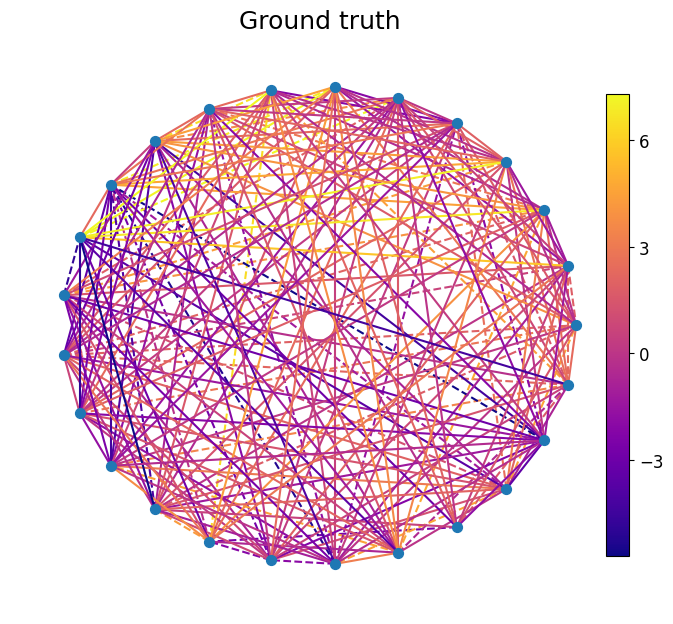

In [115]:
fig, ax = plt.subplots(figsize=(10,7.5))

nx.draw_circular(G, with_labels=False, edge_color='grey', edgelist=[],  node_size=50, width=1)

# train edges
nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edge_cmap=cmap, edge_color=y_train_vals, edgelist=train_edges, width=1.5, style='dashed')

# test edges
nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edge_cmap=cmap, edge_color=y_test_vals, edgelist=test_edges, width=1.5)


vmin = y_test_vals.min()
vmax = y_test_vals.max()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# plot the colorbar
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cax = cbar.ax  # get the ax of the colorbar
pos = cax.get_position()  # get the original position
cax.set_position([pos.x0*0.92, pos.y0, pos.width * 0.8, pos.height])  # set a new position
cax.set_frame_on(True)
cbar.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

plt.title("Ground truth", fontsize=18)

plt.show()


/var/folders/py/wfd5gjj55nx4cqtdvltb22mw0000gp/T/ipykernel_12908/1113082837.py:6: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edge_cmap=cmap, edge_color=y_train_vals, edgelist=train_edges, width=1.5, style='dashed')
/var/folders/py/wfd5gjj55nx4cqtdvltb22mw0000gp/T/ipykernel_12908/1113082837.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edge_cmap=cmap,  edge_color=prediction_mean, edgelist=test_edges, width=1.5)


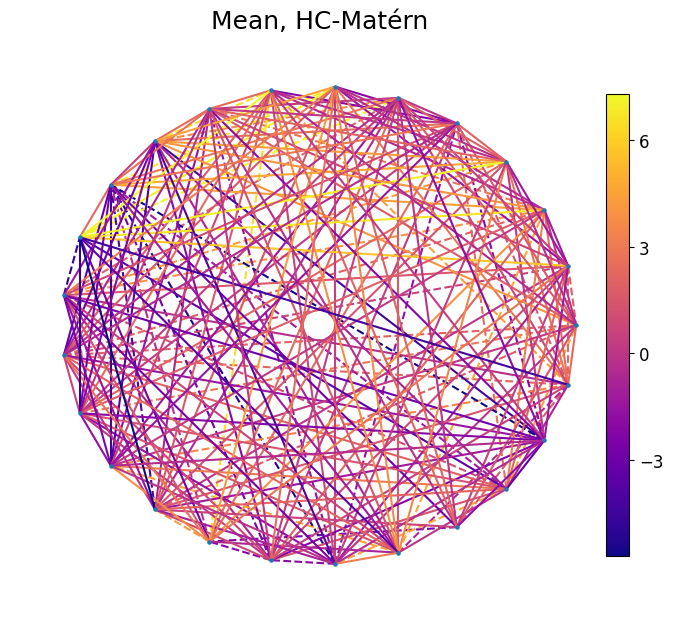

In [117]:
fig, ax = plt.subplots(figsize=(10,7.5))

nx.draw_circular(G, with_labels=False, edge_color='grey', edgelist=[], node_size=5, width=0.5)

# train edges
nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edge_cmap=cmap, edge_color=y_train_vals, edgelist=train_edges, width=1.5, style='dashed')

# test edges
nx.draw_networkx_edges(G, pos=nx.circular_layout(G), edge_cmap=cmap,  edge_color=prediction_mean, edgelist=test_edges, width=1.5)


vmin = prediction_mean.min()
vmax = prediction_mean.max()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
# plot the colorbar
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cax = cbar.ax  # get the ax of the colorbar
pos = cax.get_position()  # get the original position
cax.set_position([pos.x0*0.92, pos.y0, pos.width * 0.8, pos.height])  # set a new position
cax.set_frame_on(True)
cbar.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

plt.title("Mean, HC-Matérn", fontsize=18)


plt.show()